In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
# 设置全局字体为支持中文的字体
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 或者 'SimHei'
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [5]:
root = r'C:\Users\81004\Desktop\las_paper\ana_data\1800'
file_name = "cry_1000p_out.xyz"
#########
file_path = os.path.join(root,file_name)

In [7]:
def read_xyz_frames(file_path):
    frames = []
    current_frame = None

    with open(file_path, 'r') as file:
        lines = file.readlines()
        line_index = 0

        while line_index < len(lines):
            line = lines[line_index].strip()

            if line.isdigit():
                # 读取原子数
                if current_frame:
                    frames.append(current_frame)
                num_atoms = int(line)
                current_frame = {"num_atoms": num_atoms, "atoms": []}
                line_index += 2  # 跳过标题行 "Atoms"
            else:
                # 读取原子坐标
                if current_frame:
                    atom_data = line.split()
                    if len(atom_data) == 4:
                        element, x, y, z = atom_data
                        current_frame["atoms"].append({
                            "element": element,
                            "x": float(x),
                            "y": float(y),
                            "z": float(z)
                        })
                line_index += 1

        if current_frame:
            frames.append(current_frame)

    return frames

# 使用之前的frames列表
frames = read_xyz_frames(file_path)

# 找出最大的x、y和z值
max_x = max([max(frame["atoms"], key=lambda atom: atom["x"])["x"] for frame in frames])
max_y = max([max(frame["atoms"], key=lambda atom: atom["y"])["y"] for frame in frames])
max_z = max([max(frame["atoms"], key=lambda atom: atom["z"])["z"] for frame in frames])

print("Maximum X value:", max_x)
print("Maximum Y value:", max_y)
print("Maximum Z value:", max_z)

Maximum X value: 126.685915
Maximum Y value: 55.237748
Maximum Z value: 11.48612


In [11]:
# 根据模拟设置 box_size
box_size = np.array([max_x, max_y, max_z])  
print(box_size)

[126.685915  55.237748  11.48612 ]


In [13]:
import numpy as np

# 假设你有粒子的位置信息，shape为( num_timesteps,num_particles, 3)

# 计算均方位移
def calculate_msd(positions, L):
    positions, L = np.array(positions),np.array(L)
    num_timesteps,num_particles, _ = positions.shape
    msd = np.zeros(num_timesteps)
    L = np.array(L)
    for t in range(1, num_timesteps):
        # 计算每个粒子的位移
        displacements = positions[t] - positions[0]
        
        # 处理周期性边界条件
        displacements = displacements - L * np.round(displacements / L)
        msd[t] = np.sum(displacements**2)/num_particles
    # print(L)
    return msd

In [15]:
ana_element = ['O','Al','Li','Si']

In [17]:
def create_lists(list_names):
    list_names = list_names
    local_vars = {}
    for name in list_names:
        local_vars[name] = []
    return local_vars

In [19]:
# 筛选元素
ele_position = create_lists(ana_element)

for i_frams in range(len(frames)):
    temp_frame = frames[i_frams]['atoms']
    temp_list = []
    # 存储一帧的数据 
    temp_save = create_lists(ana_element)
    for j_atom in temp_frame:
        for k_ele in ana_element:
            # print(j_atom)
            if j_atom['element'] == k_ele:
                temp_save[k_ele].append([j_atom['x'],j_atom['y'],j_atom['z']])
    # 然后再将这一帧存进总数据库中
    for k_ele in ana_element:
        ele_position[k_ele].append(temp_save[k_ele])    

In [20]:
ele_msd = create_lists(ana_element)
for i_ele in ana_element:
    temp_position =ele_position[i_ele]
    temp_msd = calculate_msd(temp_position, box_size)
    ele_msd[i_ele]=temp_msd

In [21]:
ele_msd['O'][:10]

array([0.        , 2.04224739, 3.45806342, 4.11444992, 5.32914035,
       6.18186505, 6.75816025, 7.26621704, 8.10020817, 9.01054676])

Text(0.5, 1.0, '2K-MSD')

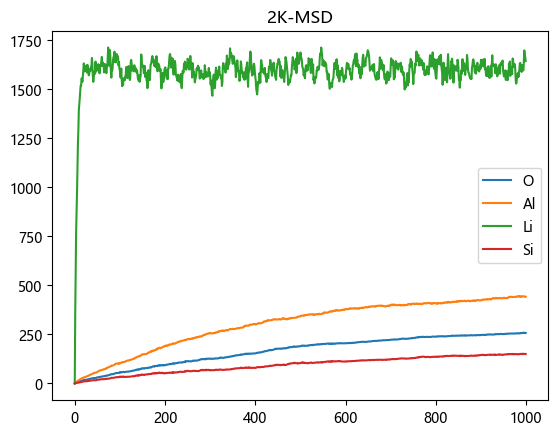

In [22]:
for i in ana_element:
    test = ele_msd[i]
    plt.plot(range(len(test)),ln(test),label=i)
plt.legend()
plt.title('2K-MSD')

Text(0.5, 1.0, '2K-MSD')

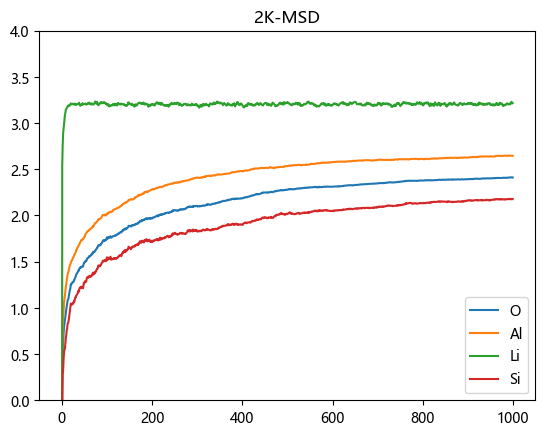

In [53]:
for i in ana_element:
    test = np.array(ele_msd[i])
    # 极小值避免log(0)
    test[test == 0] = 1e-10
    test = np.log10(test)
    plt.plot(range(len(test)),test,label=i)
plt.ylim(0,4)
plt.legend()
plt.title('2K-MSD')

# 保存数据

In [55]:
save_name = file_name.split('-')[0]+r'-msd.data'
save_path = os.path.join(root,save_name)

In [59]:
file = open(save_path,'w')
file.write('msd O Al Li Si \n')
for i_num in range(len(ele_msd['O'])):
    write_str = str(i_num/12.5)+' '
    for i_ele in ana_element:
        temp_msd = ele_msd[i_ele][i_num]
        write_str+=str(temp_msd)+' '
    file.write(write_str+'\n')
file.close()

In [201]:
len(ele_msd['O'])

301

In [285]:
save_path = r'D:\MD_file\date\0304-ptr-msd\msd-data'

In [286]:
file_name = file_path.split('\\')[-1]
temp_name = file_name.split('-')
save_name = temp_name[0] 
# print(save_name)
save = f'{save_path}\\{save_name}-msd.txt'
print(save)

D:\MD_file\date\0304-ptr-msd\msd-data\6k-msd.txt


In [287]:
ele_msd['Si'][:10]

array([  0.        , 106.00727119, 204.93733355, 302.68252189,
       398.93720942, 496.78347973, 587.11913832, 679.68966615,
       759.00107558, 840.53537685])

In [288]:
test = ele_msd
# 按照1000ps的标准进行计算
with open(save,'w') as file:
    # 先写出文件头
    file.write('Time(ps)  ')
    for i in ana_element:
        file.write(f'{i}  ')
    file.write('\n')
    # 第二行开始写MSD内容
    for i_time in range(len(ele_msd[ana_element[0]])):
        # 时间单位是10ps
        time = i_time*10
        file.write(f'{time}  ')
        # 开始写之后的MSD
        for j_ele in ana_element:
            file.write(f'{ele_msd[j_ele][i_time]}  ')
        file.write('\n')

In [65]:
position_list[0]

array([[14.379934, 32.899734, 24.50193 ],
       [24.851434,  6.874744, 19.76073 ],
       [46.776734, 37.021534, 37.13573 ],
       ...,
       [31.352034, 33.085134, 28.77403 ],
       [20.461734, 21.587434, 10.74613 ],
       [25.232034,  3.136714, 47.78733 ]])

扩散系数 D: 0.00013932811878977107 A**2/ps
R^2 值: 82.338


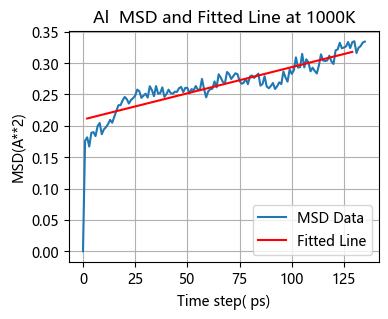

In [67]:
from scipy.stats import linregress

# 假设 msd 是你计算得到的均方位移数据
msd = msd
time = np.arange(len(msd))  # 时间步长

# 选择 MSD 数据的后几项进行拟合
fit_start_index = 2  # 选择拟合的起始索引，根据你的数据选择合适的起始位置
fit_end_index = 130
x_fit = time[fit_start_index:fit_end_index]   # 选择时间步长
y_fit = msd[fit_start_index:fit_end_index]    # 选择对应的 MSD 数据

# 线性拟合
slope, intercept, r_value, p_value, std_err = linregress(x_fit, y_fit)

# 计算扩散系数
D = slope / 6.0   # D = slope / 6  A**2/ps

# 计算 R^2 值
r_squared = r_value ** 2

# 输出结果
# print(f"拟合斜率: {slope}")
print(f"扩散系数 D: {D} A**2/ps")
print(f"R^2 值: {round(r_squared*100,3)}")
# print(f"p 值: {p_value}")
# print(f"标准误差: {std_err}")

# 绘制 MSD 数据和拟合线
plt.figure(figsize=(4, 3))
label_name = ''.join(ana_element) + '  MSD and Fitted Line at '+ file_path.split('\\')[-1][:2]+'00K'

plt.plot(time, msd, label='MSD Data')
# plt.plot(time,time**2)
plt.plot(x_fit, slope * x_fit + intercept, color='red', label='Fitted Line')
plt.xlabel('Time step( ps)')
plt.ylabel('MSD(A**2)')
plt.title(label_name)
plt.legend()
plt.grid(True)
plt.show()


# 得到各个温度下的D之后，开始拟合得到Ea和D0

In [9]:
T_list = [1000,1300,1600,1900,2200,2500]

# cube data
D_al = [0.0001393,0.000629,0.0021976 ,0.0101180 ,0.034060 ,0.0976953 ] 
D_si = [9.4151*1e-5,0.0001423,0.0005618 ,0.002351 ,0.010633,0.031827 ]
D_o = [4.1579*1e-5,0.0003308,0.0011740 ,0.004986 ,0.0197899 ,0.055200 ]
D_li = [0.138476 ,0.38037 ,0.793665 ,1.29051 ,1.887924 ,2.752457 ]


In [11]:
def cal_D_list(is_li=0):
    D = []
    if is_li==0:
        for i in range(len(D_al)):
            d_temp = (D_al[i] + D_si[i] + 4*D_o[i])/6
            D.append(d_temp)
    else:
        for i in range(len(D_al)):
            d_temp = (D_al[i] + D_si[i] + 4*D_o[i]+D_li[i])/7
            D.append(d_temp)
    return D

In [13]:
cal_D_list(is_li=0)

[6.662783333333334e-05,
 0.00034908333333333335,
 0.0012425666666666666,
 0.005402166666666666,
 0.0206421,
 0.058387049999999996]

In [15]:
cal_D_list(is_li=1)

[0.019839395285714285,
 0.054637785714285715,
 0.11444577142857142,
 0.18898900000000002,
 0.28739665714285717,
 0.4432541857142857]

In [17]:
T_list = [1000,1300,1600,1900,2200,2500]

# cube data
D_al = [0.0001393,0.000629,0.0021976 ,0.0101180 ,0.034060 ,0.0976953 ] 
D_si = [9.4151*1e-5,0.0001423,0.0005618 ,0.002351 ,0.010633,0.031827 ]
D_o = [4.1579*1e-5,0.0003308,0.0011740 ,0.004986 ,0.0197899 ,0.055200 ]
D_li = [0.138476 ,0.38037 ,0.793665 ,1.29051 ,1.887924 ,2.752457 ]

def cal_D_list0(is_li=0,is_begin=1):
    D = []
    if is_li==0:
        for i in range(len(D_al)-is_begin):
            i = i+is_begin
            d_temp = (D_al[i] + D_si[i] + 4*D_o[i])/6
            D.append(d_temp)
    else:
        for i in range(len(D_al)-is_begin):
            i = i + is_begin
            d_temp = (D_al[i] + D_si[i] + 4*D_o[i]+D_li[i])/7
            D.append(d_temp)
    return T_list[is_begin:],D

In [19]:
cal_D_list0(0,0)

([1000, 1300, 1600, 1900, 2200, 2500],
 [6.662783333333334e-05,
  0.00034908333333333335,
  0.0012425666666666666,
  0.005402166666666666,
  0.0206421,
  0.058387049999999996])

In [98]:
# 存储数据文件的位置
save_fig = r'C:\Users\81004\Desktop\data_corning\Li'

[0.000625   0.00052632 0.00045455 0.0004    ]
前因子 D0: 73.80097447085623
活化能 E_A: 1.444546223003483 eV
R^2 值: 99.774


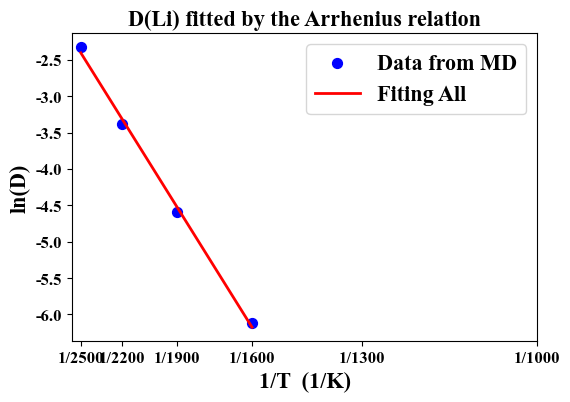

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import font_manager  # 确保导入font_manager
# 计算只有Li的扩散系数
T_list0,D_list0 = T_list[2:],D_al[2:]

# 假设你有以下数据（温度 T 和扩散系数 D）
T = np.array(T_list0)  # 温度，单位：K
D_APS = np.array(D_list0)  # 扩散系数，单位：A^2/ps
# D_ms = D_APS*10**(-8)

# 玻尔兹曼常数（单位：J/K）
k_B = 1.380649e-23

# 计算 ln(D) 和 1/T
ln_D = np.log(D_APS)
inv_T = 1 / T

# 使用线性回归拟合 ln(D) = ln(D0) - E_A / k_B * (1/T)
slope, intercept, r_value, p_value, std_err = stats.linregress(inv_T, ln_D)

# 提取拟合参数
D_0 = np.exp(intercept)  # D0 为截距的指数
E_A_J = -slope * k_B  # E_A 为斜率乘以玻尔兹曼常数，单位为 J
E_A_eV = E_A_J / 1.60218e-19  # 将 E_A 转换为 eV
print(inv_T)
# 打印拟合结果
print(f"前因子 D0: {D_0}")
print(f"活化能 E_A: {E_A_eV} eV")

####
# 计算 R^2 值
r_squared = r_value ** 2

print(f"R^2 值: {round(r_squared*100,3)}")

# 设置图像大小
plt.figure(figsize=(6, 4))

# 绘制拟合结果
plt.scatter(inv_T, ln_D,s=50, label='Data from MD',color='blue')
plt.plot(inv_T, intercept + slope * inv_T, linewidth = 2,label='Fiting All', color='red')
# 绘制四个点的
# plt.plot(x_4point, y_4point, linewidth = 2,label='Fiting 4 points', color='green')
#######
plt.xlabel('1/T  (1/K)', fontsize=16, fontweight='bold', family='Times New Roman')
plt.ylabel('ln(D)', fontsize=16, fontweight='bold', family='Times New Roman')
plt.title('D(Li) fitted by the Arrhenius relation',fontsize=16, fontweight='bold', family='Times New Roman')

######
# 自定义 x 轴的刻度位置和标签

custom_ticks = [ 1/2500,1/2200,1/1900,1/1600,1/1300,1/1000]  # 自定义的x坐标点
custom_labels = ['1000', '1300', '1600', '1900', '2200', '2500']  # 对应的标签
custom_labels = ['1/2500', '1/2200', '1/1900', '1/1600', '1/1300', '1/1000']  # 对应的标签
# 设置x轴的自定义刻度和标签
plt.xticks(custom_ticks, custom_labels)

# 单独设置坐标轴刻度字体 time new roman
plt.xticks(fontsize=12, fontweight='bold', family='Times New Roman')  # 设置x轴刻度
plt.yticks(fontsize=12, fontweight='bold', family='Times New Roman')  # 设置y轴刻度
##########
# 创建字体属性对象
# 创建字体属性对象
font_properties = font_manager.FontProperties(family='Times New Roman', weight='bold', size=16)

# 设置图例的字体属性
plt.legend(fontsize=12, prop=font_properties)

### 存储数据文件的位置
#save_fig = r'C:\Users\81004\Desktop\data_corning\Si_fit.jpg'
# 保存图像
#plt.savefig(save_fig, dpi=300, bbox_inches='tight')  # dpi设置分
######
plt.show()

[0.000625   0.00052632 0.00045455 0.0004    ]
前因子 D0: 73.80097447085623
活化能 E_A: 1.444546223003483 eV
R^2 值: 99.774


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\81004\\Desktop\\data_corning\\Si_fit.jpg'

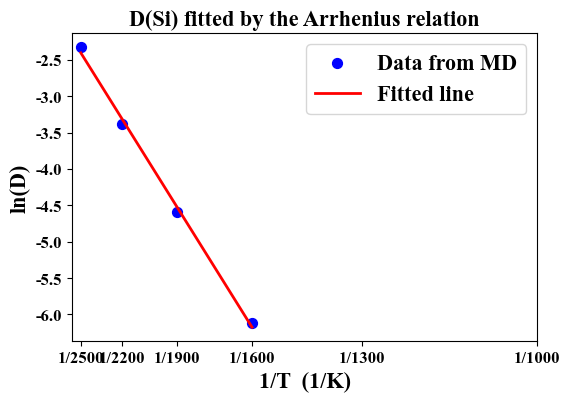

In [33]:
#  作为二次的绘图
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from matplotlib import font_manager  # 确保导入font_manager
# 计算只有Li的扩散系数
T_list0,D_list0 = T_list[2:],D_al[2:]

# 假设你有以下数据（温度 T 和扩散系数 D）
T = np.array(T_list0)  # 温度，单位：K
D_APS = np.array(D_list0)  # 扩散系数，单位：A^2/ps
# D_ms = D_APS*10**(-8)

# 玻尔兹曼常数（单位：J/K）
k_B = 1.380649e-23

# 计算 ln(D) 和 1/T
ln_D = np.log(D_APS)
inv_T = 1 / T

# 使用线性回归拟合 ln(D) = ln(D0) - E_A / k_B * (1/T)
slope, intercept, r_value, p_value, std_err = stats.linregress(inv_T, ln_D)

# 提取拟合参数
D_0 = np.exp(intercept)  # D0 为截距的指数
E_A_J = -slope * k_B  # E_A 为斜率乘以玻尔兹曼常数，单位为 J
E_A_eV = E_A_J / 1.60218e-19  # 将 E_A 转换为 eV
print(inv_T)
# 打印拟合结果
print(f"前因子 D0: {D_0}")
print(f"活化能 E_A: {E_A_eV} eV")

####
# 计算 R^2 值
r_squared = r_value ** 2

print(f"R^2 值: {round(r_squared*100,3)}")

# 设置图像大小
plt.figure(figsize=(6, 4))

# 绘制拟合结果
plt.scatter(inv_T, ln_D,s=50, label='Data from MD',color='blue')
plt.plot(inv_T, intercept + slope * inv_T, linewidth = 2,label='Fitted line', color='red')

x_4point,y_4point = inv_T,intercept + slope * inv_T
plt.xlabel('1/T  (1/K)', fontsize=16, fontweight='bold', family='Times New Roman')
plt.ylabel('ln(D)', fontsize=16, fontweight='bold', family='Times New Roman')
plt.title('D(Si) fitted by the Arrhenius relation',fontsize=16, fontweight='bold', family='Times New Roman')

######
# 自定义 x 轴的刻度位置和标签

custom_ticks = [ 1/2500,1/2200,1/1900,1/1600,1/1300,1/1000]  # 自定义的x坐标点
custom_labels = ['1000', '1300', '1600', '1900', '2200', '2500']  # 对应的标签
custom_labels = ['1/2500', '1/2200', '1/1900', '1/1600', '1/1300', '1/1000']  # 对应的标签
# 设置x轴的自定义刻度和标签
plt.xticks(custom_ticks, custom_labels)

# 单独设置坐标轴刻度字体 time new roman
plt.xticks(fontsize=12, fontweight='bold', family='Times New Roman')  # 设置x轴刻度
plt.yticks(fontsize=12, fontweight='bold', family='Times New Roman')  # 设置y轴刻度
##########
# 创建字体属性对象
# 创建字体属性对象
font_properties = font_manager.FontProperties(family='Times New Roman', weight='bold', size=16)

# 设置图例的字体属性
plt.legend(fontsize=12, prop=font_properties)

### 存储数据文件的位置
save_fig = r'C:\Users\81004\Desktop\data_corning\Si_fit.jpg'
# 保存图像
plt.savefig(save_fig, dpi=300, bbox_inches='tight')  # dpi设置分
######
plt.show()

In [102]:
# 
# 存储数据文件的位置
save_fig = r'C:\Users\81004\Desktop\data_corning\Li_fit.jpg'
# 保存图像
plt.savefig(save_fig, dpi=300, bbox_inches='tight')  # dpi设置分

<Figure size 640x480 with 0 Axes>

In [30]:
print('1/T')
for i in  range(len(inv_T)):
    print(inv_T[i])
print('log_D')
for i in  range(len(inv_T)):
    print(ln_D[i])
print('Fitted_D')
for i in  range(len(inv_T)):
    print(intercept + slope * inv_T[i])


1/T
0.000625
0.0005263157894736842
0.00045454545454545455
0.0004
log_D
-0.23109382112358978
0.2550374890810302
0.6354778126757972
1.0124939673309996
Fitted_D
-0.2557894814445789
0.28244231069718007
0.6738836140730049
0.9713790046386315


前因子 D0: 4.471338098067118
活化能 E_A: 0.5105865542576594 eV
R^2 值: 99.048


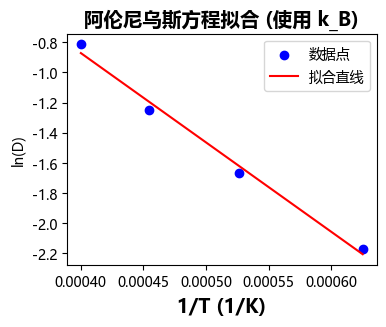

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

T_list0,D_list0 = cal_D_list0(is_li=1,is_begin=2)


# 假设你有以下数据（温度 T 和扩散系数 D）
T = np.array(T_list0)  # 温度，单位：K
D_APS = np.array(D_list0)  # 扩散系数，单位：A^2/ps
# D_ms = D_APS*10**(-8)

# 玻尔兹曼常数（单位：J/K）
k_B = 1.380649e-23

# 计算 ln(D) 和 1/T
ln_D = np.log(D_APS)
inv_T = 1 / T

# 使用线性回归拟合 ln(D) = ln(D0) - E_A / k_B * (1/T)
slope, intercept, r_value, p_value, std_err = stats.linregress(inv_T, ln_D)

# 提取拟合参数
D_0 = np.exp(intercept)  # D0 为截距的指数
E_A_J = -slope * k_B  # E_A 为斜率乘以玻尔兹曼常数，单位为 J
E_A_eV = E_A_J / 1.60218e-19  # 将 E_A 转换为 eV

# 打印拟合结果
print(f"前因子 D0: {D_0}")
print(f"活化能 E_A: {E_A_eV} eV")

####
# 计算 R^2 值
r_squared = r_value ** 2

print(f"R^2 值: {round(r_squared*100,3)}")

# 设置图像大小
plt.figure(figsize=(4, 3))

# 绘制拟合结果
plt.scatter(inv_T, ln_D, label='数据点', color='blue')
plt.plot(inv_T, intercept + slope * inv_T, label='拟合直线', color='red')
plt.xlabel('1/T (1/K)', fontsize=14, fontweight='bold')
plt.ylabel('ln(D)')
plt.title('阿伦尼乌斯方程拟合 (使用 k_B)', fontsize=14, fontweight='bold')
plt.legend()
plt.show()

In [34]:
for i in  range(len(inv_T)):
    print(intercept + slope * inv_T[i])

-2.20551439132345
-1.6207982693312764
-1.1955501806096962
-0.8723616331812949


# 拟合函数曲线

In [36]:
D_t(100,4.7,0.589)

NameError: name 'D_t' is not defined

In [100]:
# 2100K时玻璃的焓
a_list = [-51021.406,-51045.962,-50925.553,-51017.588,-50953.872,-50734.092,-50952.205,-50645.081,-51016.514]

In [65]:
b_list=[-51016.471,-50807.994,-50855.995,-50900.762,-50883.817 ,-50979.825,-51028.304,-50671.456 ,
-50961.368,-50902.918,-50837.772,-51169.335,-50874.396,-51014.337,-50953.852 ,-50935.308,
-50982.945 ,-50921.731,-50935.797,-50958.096 ,-50915.619]

In [96]:
Enthalpy_mean = np.array(b_list).mean()
mean_glass_e = Enthalpy_mean/4011
print(mean_glass_e)

-12.697321627429332


In [98]:
cry_e = (glass_cry_sum-mean_glass_e*3003)/1008
print(cry_e)

NameError: name 'glass_cry_sum' is not defined

In [100]:
mean_glass_e - cry_e

NameError: name 'cry_e' is not defined

In [102]:
glass_cry = [-51173.197,-51226.817,-51110.025,-51165.825,-50991.537,-51072.235,-50962.452,-51173.864,-51146.057,-51185.273,-50879.726
,-50990.255,-51105.253,-50934.39,-51071.55,-50995.193,-50907.90,-50954.92,-51042.266,-51137.752,-51037.194,-51193.094
,-51116.209,-51158.501,-51165.033,-50985.16,-51098.22,-51192.25,-50959.611,-51087.993,-50992.592,-51043.346,-51099.469,-51122.601,-51036.053,-50989.969,-50979.894,-51109.486]

-51058.35639393939


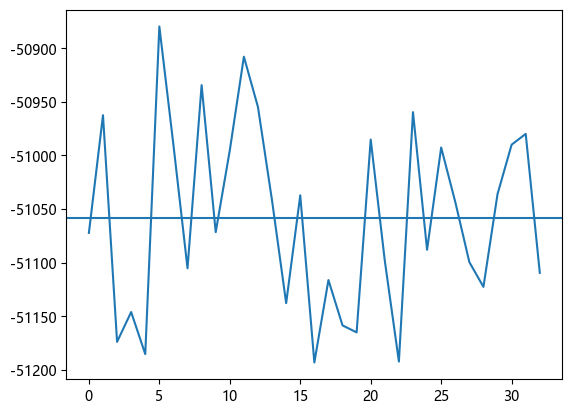

In [104]:
test = glass_cry[5:]
mean_test = np.array(test).mean()
x = range(len(test))
y = test
plt.plot(x,y)
plt.axhline(mean_test)
print(mean_test)
glass_cry_sum = mean_test

In [87]:
# def parameters
PARA_Kb = 8.617333262145*10**(-5)  # eV·K−1
def delta_fu(T,Tm,delta_hm):
    return delta_hm*(Tm-T)/Tm

def thermodynamic(T,Tm,delta_hm):
    delta_u = delta_fu(T,Tm,delta_hm)
    return 1-np.exp(-delta_u/(PARA_Kb*T))
    
def kinetic_BGJ(T):
    return (3*PARA_Kb*T)**0.5
def D_t(T,D0,Ea):
    PARA_Kb = 8.61733*10**(-5)  # eV·K−1
    return D0*np.exp(-1*Ea/(PARA_Kb*T))

In [91]:
x_origin = np.linspace(100,2500,100)
y = D_t(x_origin,4.58,0.95)
# plt.plot(x_origin,y)

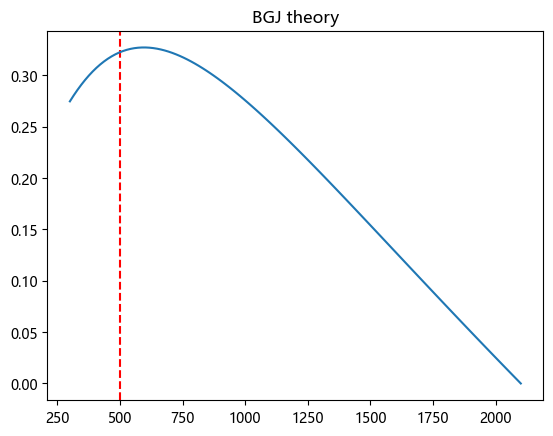

In [285]:
x_origin = np.linspace(300,2100,120)
y = kinetic_BGJ(x_origin)*thermodynamic(x_origin,2100,0.12837)
plt.title('BGJ theory')
plt.axvline(500,color='r',linestyle='--',label='500')
plt.plot(x_origin,y)

In [95]:
y = thermodynamic(x_origin,2100,0.12837)
#plt.plot(x_origin,y)

In [97]:
y =  D_t(x_origin,4.74229,0.58897)
#plt.plot(x_origin,y)

In [141]:
(1.199419+1.4758)/2

1.3376095000000001

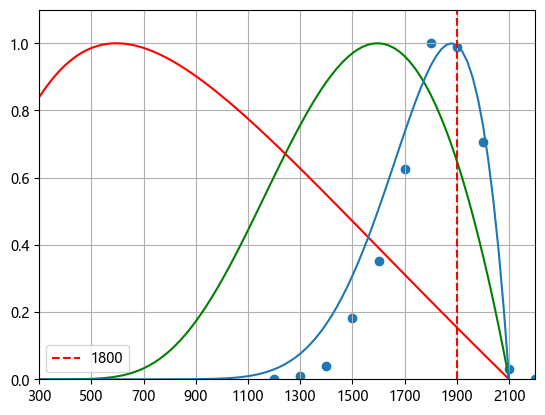

In [347]:
x_origin = np.linspace(300,2100,91)
vt = D_t(x_origin,50.91564847903018,1.475840774318781)*thermodynamic(x_origin,2100,0.12837)
ymax = max(vt)
# 获取当前y轴的最大值
vt_li = D_t(x_origin,4.4713380,0.5105865)*thermodynamic(x_origin,2100,0.12837)
y_max_li= max(vt_li)
plt.plot(x_origin,vt_li/y_max_li,color='g')
# MD数据
x_md = np.linspace(1200,2200,11)
y_md = np.array([0,0.0089,0.0404,0.1825,0.3514,0.626,1,0.9893,0.7058,0.0302,0])
plt.scatter(x_md,y_md)
####
y_bgj = kinetic_BGJ(x_origin)*thermodynamic(x_origin,2100,0.12837)
y_max_bgj = max(y_bgj)
plt.plot(x_origin,y_bgj/y_max_bgj,color='r')
# WF拟合数据
plt.ylim(0,1.1)
plt.plot(x_origin,vt/ymax)
plt.grid(True)
plt.axvline(1900,color='r',linestyle='--',label='1800')
plt.xlim(300,2200)
plt.xticks(np.arange(300, 2200, 200))
plt.legend()

In [359]:
test = y_bgj
temp_max = max(test)
for i in test:
    print(i/temp_max)

0.8396075808245144
0.8626053738006858
0.883631190530847
0.9027117293759396
0.9198838798865393
0.9351939938466624
0.9486965692811121
0.9604526919119794
0.9705284481597084
0.9789934337605455
0.9859194222625048
0.991379219455278
0.9954457064919544
0.998191061142808
0.999686139788142
1.0
0.9991995432623827
0.9973492584728944
0.9945110486737917
0.9907441255529222
0.9861049583809777
0.9806472660674681
0.9744220428506873
0.9674776097571154
0.9598596853694304
0.9516114706405847
0.9427737435024859
0.9333849598632131
0.9234813582880711
0.913097066237933
0.9022642062120693
0.8910130005287763
0.8793718737901651
0.8673675523299081
0.8550251601452077
0.8423683109756255
0.8294191963191652
0.8161986692763269
0.8027263241908954
0.7890205721162032
0.7750987121810139
0.7609769989628867
0.7466707060011799
0.7321941855987331
0.7175609250721988
0.7027835996172976
0.6878741219579507
0.672843688948111
0.6577028252928833
0.642461424551668
0.6271287875810686
0.6117136585694722
0.5962242588088501
0.5806683183426

In [351]:
abc = np.linspace(300,2100,91)
for i in abc:
    #print(i)

SyntaxError: incomplete input (2707548328.py, line 3)

In [339]:
18*3

54

In [313]:
np.linspace(10,20,11)

array([10., 11., 12., 13., 14., 15., 16., 17., 18., 19., 20.])

In [147]:
for i in  vt:
    print(i/ymax)

0.04789628734134091
0.05136091078757958
0.05501668196720911
0.0588700688853223
0.06292751868403498
0.06719544237736391
0.07168019905019599
0.07638807953884806
0.08132528961175306
0.08649793266976931
0.09191199198651089
0.09757331250993609
0.10348758224719631
0.10966031325545363
0.11609682226201169
0.12280221093767694
0.1297813458477684
0.13703883810563872
0.14457902275394327
0.15240593789920262
0.16052330362546247
0.16893450071303406
0.17764254918843556
0.18665008673172445
0.1959593469674236
0.2055721376652171
0.21548981887647461
0.2257132810325632
0.2362429230306705
0.24707863033266209
0.2582197531021933
0.26966508440498904
0.2814128384968314
0.29346062922339694
0.3058054485556627
0.3184436452841073
0.33137090389445883
0.34458222364719704
0.35807189788246463
0.3718334935714784
0.3858598311348862
0.40014296454796716
0.41467416175184185
0.42944388538928
0.44444177388297296
0.4596566228734868
0.47507636703338135
0.4906880622733166
0.5064778683552275
0.5224310319269495
0.5385318699919495


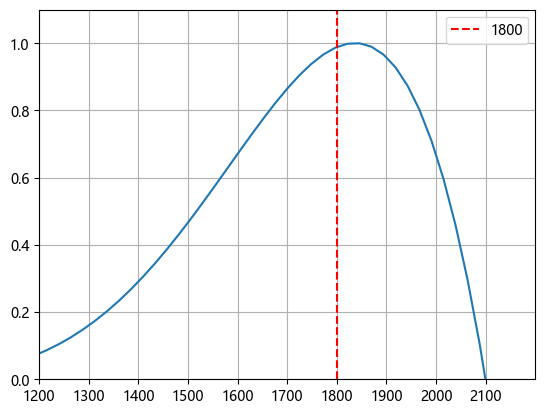

In [101]:
vt = D_t(x_origin,11.0959,1.19941)*thermodynamic(x_origin,2100,0.12837)
# 获取当前y轴的最大值
ymax = max(vt)
plt.ylim(0,1.1)
plt.plot(x_origin,vt/ymax)
plt.grid(True)
plt.axvline(1800,color='r',linestyle='--',label='1800')
plt.xlim(1200,2200)
plt.xticks(np.arange(1200, 2200, 100))
plt.legend()

In [137]:
#np.linspace(1200,2200,130)